## Plot results for panels project
- model-predicted panel labels
- NEC calculations for existing loads

In [10]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import re
import numpy as np
import math
import random

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)


In [11]:
model = "16570" # <--- "162", "16570"

main_dir = Path("/Users/lliu2/Documents/Documents_Files/Lab Call 5A - electrical panel constraints/FY23/Panels Estimation/")
model_file = main_dir / f"euss1_2018_results_up00_clean__model_{model}__tsv_based__predicted_panels_probablistically_assigned.csv"
model_file_prob = main_dir / f"euss1_2018_results_up00_clean__model_{model}__tsv_based__predicted_panels_in_probability.csv"
nec_file = main_dir / "euss1_2018_results_up00_clean__existing_load.csv"
model_training_file = Path("/Users/lliu2/Documents/GitHub/resstock2/Electrical_Panels_EUSS/panels/model_20240122/model_data_16570.xlsx")


### Specify filters to apply to all data

In [12]:
### specify filters as query
has_filter = True # <---

if has_filter:
    filter_query = "`build_existing_model.state` == 'CA' & `build_existing_model.geometry_building_type_recs` == 'Single-Family Detached'" # <---
    folder_ext = "__CA_SFD_only" # <---
    print(f"All input datasets will be filtered using query statement: \n{filter_query}")
else:
    filter_query = ""
    folder_ext = ""
    print("No filter will be applied to the input datasets")

All input datasets will be filtered using query statement: 
`build_existing_model.state` == 'CA' & `build_existing_model.geometry_building_type_recs` == 'Single-Family Detached'


In [13]:

output_dir = main_dir / "plots" / f"model_{model}_for_paper{folder_ext}"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"All results will be output to: \n{output_dir}")

All results will be output to: 
/Users/lliu2/Documents/Documents_Files/Lab Call 5A - electrical panel constraints/FY23/Panels Estimation/plots/model_16570_for_paper__CA_SFD_only


### Transform binned output into weighted representative values

In [14]:
def undummify_input_data(df, prefix_sep="__"):
    # undummy categorical columns
    cat_cols = [x for x in df.columns if prefix_sep in x]
    other_cols = [x for x in df.columns if x not in cat_cols]
    dfd = undummify(df[cat_cols], prefix_sep=prefix_sep)

    # bin sqft
    para = "geometry_floor_area"
    bins = ["0-499", "500-749", "750-999", "1000-1499", "1500-1999", "2000-2499", "2500-2999", "3000-3999", "4000+"]
    bin_edges = [int(x.split("-")[0].split("+")[0]) for x in bins]
    dfd.loc[df["sqft"]>=bin_edges[-1], para] = bins[-1]
    for edge, label in zip(reversed(bin_edges[1:]), reversed(bins[:-1])):
        dfd.loc[df["sqft"]<edge, para] = label

    dfd = pd.concat([dfd, df[other_cols]], axis=1)

    return dfd


def undummify(df, prefix_sep="__"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)

    return undummified_df


def save_filtered_df_to_file(df, original_filename: Path, output_dir: Path | None):
    new_file = original_filename.stem + "__filtered.csv"
    if output_dir is None:
        new_filename = original_filename.parent / new_file
    else:
        new_filename = output_dir / new_file

    df.to_csv(new_filename, index=False)



In [15]:
model_file.stem

'euss1_2018_results_up00_clean__model_16570__tsv_based__predicted_panels_probablistically_assigned'

In [16]:
# Load training data and undummify:
dfd = pd.read_excel(model_training_file, sheet_name=f"input_{model}", header=0)
output_mapping = {
            0: "100",
            1: "101-199",
            2: "200",
            3: "201+",
            4: "<100", # "lt_100",
        }
dfd["panel_amp_pre_bin"] = dfd["panel_amp_pre_bin"].map(output_mapping)
dfd = undummify_input_data(dfd)
dfd

,geometry_building_type_recs,water_heater_fuel,hvac_cooling_type,heating_fuel,clothes_dryer,vintage,cooking_range,geometry_floor_area,sqft,panel_amp_pre_bin,panel_amp_pre
0,Single-Family Detached,Natural Gas,None,Natural Gas,"Gas, 100% Usage",lt_1940,"Gas, 100% Usage",1000-1499,1428,100,100
1,Single-Family Detached,Natural Gas,Central AC,Natural Gas,"Electric, 100% Usage",1950s,"Electric, 100% Usage",1000-1499,1382,100,100
2,Single-Family Detached,Natural Gas,None,Natural Gas,"Gas, 100% Usage",lt_1940,"Gas, 100% Usage",1500-1999,1611,200,200
3,Single-Family Detached,Natural Gas,Room AC,Natural Gas,"Gas, 100% Usage",1950s,"Gas, 100% Usage",1000-1499,1025,<100,30
4,Single-Family Attached,Natural Gas,Central AC,Natural Gas,"Electric, 100% Usage",1970s,"Electric, 100% Usage",1000-1499,1204,100,100
...,...,...,...,...,...,...,...,...,...,...,...
5097,Single-Family Detached,Natural Gas,Central AC,Natural Gas,"Electric, 100% Usage",1960s,"Gas, 100% Usage",1500-1999,1664,200,200
5098,Single-Family Detached,Natural Gas,Central AC,Natural Gas,"Gas, 100% Usage",1970s,"Electric, 100% Usage",1500-1999,1586,100,100
5099,Single-Family Detached,Natural Gas,None,Natural Gas,"Electric, 100% Usage",1980s,"Electric, 100% Usage",1500-1999,1517,200,200
5100,Single-Family Detached,Natural Gas,Central AC,Natural Gas,"Electric, 100% Usage",1980s,"Gas, 100% Usage",1000-1499,1367,101-199,125


### Pick out standard sizes for each bin's representative numbers:
value (top # place mode):
- <100: 90(1st), 70(2nd), 60(3rd), 30(4th)
- 101-199: 125(1st), 150(2nd), 175(4th) # note: 120(3rd) and 110(5th) will be combined with 125
- 201+: [225, 250, 300, 350, 400, 500, ..., 1000], based on top 5 modes: [250, 300, 225, 400, 220]

Using this to visualize:\
`dfd.loc[(dfd["panel_amp_pre"]<1000) & (dfd["panel_amp_pre_bin"]=="<100"), "panel_amp_pre"].value_counts().sort_index()`\
`dfd.loc[dfd["panel_amp_pre"]<10000,["panel_amp_pre_bin", "panel_amp_pre"]].boxplot(by="panel_amp_pre_bin");
plt.show()`


In [17]:
# standardize panel_amp_pre values by rounding to the nearest bin defined above
standard_sizes = {
    "<100": np.array([30, 60, 70, 90]),
    "100": np.array([100]),
    "101-199": np.array([125, 150, 175]),
    "200": np.array([200]),
    "201+": np.concatenate([
        np.array([225, 250, 300, 350]), 
        np.arange(400, 1100, 100)
    ])
}
for lab, std_sizes in standard_sizes.items():
    cond = dfd["panel_amp_pre_bin"]==lab
    dfd.loc[cond, "panel_amp_pre_std"] = dfd.loc[cond, "panel_amp_pre"].apply(lambda x: std_sizes[np.argmin(np.abs(std_sizes/x-1))])

dfd


,geometry_building_type_recs,water_heater_fuel,hvac_cooling_type,heating_fuel,clothes_dryer,vintage,cooking_range,geometry_floor_area,sqft,panel_amp_pre_bin,panel_amp_pre,panel_amp_pre_std
0,Single-Family Detached,Natural Gas,None,Natural Gas,"Gas, 100% Usage",lt_1940,"Gas, 100% Usage",1000-1499,1428,100,100,100.0
1,Single-Family Detached,Natural Gas,Central AC,Natural Gas,"Electric, 100% Usage",1950s,"Electric, 100% Usage",1000-1499,1382,100,100,100.0
2,Single-Family Detached,Natural Gas,None,Natural Gas,"Gas, 100% Usage",lt_1940,"Gas, 100% Usage",1500-1999,1611,200,200,200.0
3,Single-Family Detached,Natural Gas,Room AC,Natural Gas,"Gas, 100% Usage",1950s,"Gas, 100% Usage",1000-1499,1025,<100,30,30.0
4,Single-Family Attached,Natural Gas,Central AC,Natural Gas,"Electric, 100% Usage",1970s,"Electric, 100% Usage",1000-1499,1204,100,100,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5097,Single-Family Detached,Natural Gas,Central AC,Natural Gas,"Electric, 100% Usage",1960s,"Gas, 100% Usage",1500-1999,1664,200,200,200.0
5098,Single-Family Detached,Natural Gas,Central AC,Natural Gas,"Gas, 100% Usage",1970s,"Electric, 100% Usage",1500-1999,1586,100,100,100.0
5099,Single-Family Detached,Natural Gas,None,Natural Gas,"Electric, 100% Usage",1980s,"Electric, 100% Usage",1500-1999,1517,200,200,200.0
5100,Single-Family Detached,Natural Gas,Central AC,Natural Gas,"Electric, 100% Usage",1980s,"Gas, 100% Usage",1000-1499,1367,101-199,125,125.0


In [18]:
# turn standardized panel amps into rep value distribution
gb = ["panel_amp_pre_bin",]
panel_value_dist = (dfd.groupby(gb+["panel_amp_pre_std"])["sqft"].count() / dfd.groupby(gb)["sqft"].count()
                   ).rename("prob").reset_index(level='panel_amp_pre_std')
panel_value_dist = panel_value_dist.groupby(level=gb).agg({'panel_amp_pre_std': list, 'prob': list}).agg(tuple, axis=1).rename("panel_amp_dist")
panel_value_dist

panel_amp_pre_bin
100                                         ([100.0], [1.0])
101-199    ([125.0, 150.0, 175.0], [0.8530183727034121, 0...
200                                         ([200.0], [1.0])
201+       ([225.0, 250.0, 300.0, 350.0, 400.0, 500.0, 60...
<100       ([30.0, 60.0, 70.0, 90.0], [0.0462427745664739...
Name: panel_amp_dist, dtype: object

In [19]:
def sample_panel_size_unweighted(x):
    """ sample panel size with unweighted (i.e., equally weighted) """
    if x == "<100":
        labels = np.array([30, 60, 70, 90])
        weights = np.ones(len(labels))
    elif x == "101-199":
        labels = np.array([125, 150, 175])
        weights = np.ones(len(labels))
    elif x == "201+":
        labels = np.concatenate([
            np.array([225, 250, 300, 350]), 
            np.arange(400, 1100, 100)
        ])
        weights = np.ones(len(labels))
    else:
        return int(x)
    return random.choices(labels, weights=weights, k=1)[0]

# for use with rep value distribution
def weighted_sample(x):
    return random.choices(x[0], weights=x[1], k=1)[0]
    

In [20]:
### rep value lookup derived directly from data is all over the place... so we probably need to create this manually...
dfd_lkup = dfd.copy()
dfd_lkup["building_type"] = dfd_lkup["geometry_building_type_recs"].map({
    "Mobile Home": "SFD/MH", 
    "Multi-Family with 2 - 4 Units": "MF",
    "Multi-Family with 5+ Units": "MF", 
    "Single-Family Attached": "SFA",
    "Single-Family Detached": "SFD/MH", 
})
dfd_lkup.groupby(["building_type", "panel_amp_pre_bin"])["panel_amp_pre"].mean()

building_type  panel_amp_pre_bin
MF             100                   100.000000
               101-199               124.285714
               200                   200.000000
               201+                 5112.500000
               <100                   20.000000
SFA            100                   100.000000
               101-199               128.015873
               200                   200.000000
               201+                  359.000000
               <100                   79.583333
SFD/MH         100                   100.000000
               101-199               129.227723
               200                   200.000000
               201+                  399.919355
               <100                   85.567568
Name: panel_amp_pre, dtype: float64

In [21]:
dfd_lkup.loc[dfd_lkup["geometry_floor_area"].isin(["0-499", "500-749"])]\
.groupby(["geometry_floor_area", "panel_amp_pre_bin"])["panel_amp_pre"].describe() #.agg(["count", "mean"])

count        mean         std    min  \
geometry_floor_area panel_amp_pre_bin                                         
0-499               100                  9.0  100.000000    0.000000  100.0   
                    101-199              7.0  128.571429    9.449112  125.0   
                    200                  1.0  200.000000         NaN  200.0   
500-749             100                 53.0  100.000000    0.000000  100.0   
                    101-199             49.0  127.653061   10.108888  110.0   
                    200                 24.0  200.000000    0.000000  200.0   
                    201+                15.0  414.133333  198.783395  202.0   
                    <100                 8.0   51.250000   26.958964   20.0   

                                         25%    50%    75%    max  
geometry_floor_area panel_amp_pre_bin                              
0-499               100                100.0  100.0  100.0  100.0  
                    101-199            125.0  125.0  125.0  150.0  
                    200                200.0  200.0  200.0  200.0  
500-749             100                100.0  100.0  100.0  100.0  
                    101-199            125.0  125.0  125.0  175.0  
                    200                200.0  200.0  200.0  200.0  
                    201+               230.0  365.0  575.0  795.0  
                    <100                30.0   45.0   72.5   90.0

In [22]:
dfd_lkup.loc[(dfd_lkup["geometry_floor_area"].isin(["500-749"])) & (dfd_lkup["panel_amp_pre_bin"]=="201+"), 
["geometry_floor_area", "geometry_building_type_recs", "panel_amp_pre_bin", "panel_amp_pre"]]

,geometry_floor_area,geometry_building_type_recs,panel_amp_pre_bin,panel_amp_pre
292,500-749,Single-Family Attached,201+,220
810,500-749,Single-Family Detached,201+,235
1179,500-749,Single-Family Attached,201+,465
1542,500-749,Single-Family Attached,201+,650
2444,500-749,Single-Family Attached,201+,300
3194,500-749,Single-Family Detached,201+,500
3347,500-749,Mobile Home,201+,220
3357,500-749,Single-Family Attached,201+,650
3485,500-749,Single-Family Detached,201+,365
3658,500-749,Single-Family Detached,201+,275


In [23]:
### predicted panel sizes
method = "weighted" # <--- unweighted, weighted, lookup (still need to be constructed)

df = pd.read_csv(model_file, low_memory=False, keep_default_na=False).query(filter_query).reset_index(drop=True)
if has_filter:
    save_filtered_df_to_file(df, model_file, output_dir=output_dir)
df["predicted_panel_amp"] = df["predicted_panel_amp"].astype(str)

# sample exact values for panel labels
random.seed(10)
if method == "unweighted":
    df["predicted_panel_amp_exact"] = df["predicted_panel_amp"].apply(sample_panel_size_unweighted).astype(int)
elif method == "weighted":
    df["predicted_panel_amp_exact"] = df["predicted_panel_amp"].map(panel_value_dist).apply(weighted_sample).astype(int)
else:
    raise NotImplementedError(f"{method=} not implemented")

categories = ["<100", "100", "101-199", "200", "201+"]
df["predicted_panel_amp"] = pd.Categorical(df["predicted_panel_amp"], ordered=True, categories=categories)

dfm = pd.read_csv(model_file_prob, low_memory=False, keep_default_na=False).query(filter_query).reset_index(drop=True)
if has_filter:
    save_filtered_df_to_file(dfm, model_file_prob, output_dir=output_dir)
dfm = pd.concat([dfm, df[["predicted_panel_amp", "predicted_panel_amp_exact"]]], axis=1)
del df

# occupied only
dfm = dfm.loc[dfm["build_existing_model.vacancy_status"]=="Occupied"].reset_index(drop=True)
dfm

,building_id,completed_status,build_existing_model.sample_weight,build_existing_model.geometry_building_horizontal_location_sfa,build_existing_model.mechanical_ventilation,build_existing_model.door_area,build_existing_model.range_spot_vent_hour,build_existing_model.hvac_shared_efficiencies,build_existing_model.eaves,build_existing_model.hvac_heating_efficiency,...,upgrade_costs.wall_area_above_grade_exterior_ft_2,upgrade_costs.wall_area_below_grade_ft_2,upgrade_costs.window_area_ft_2,100,101-199,200,201+,<100,predicted_panel_amp,predicted_panel_amp_exact
0,16,Success,242.131013,None,None,20 ft^2,Hour18,None,2 ft,"Fuel Furnace, 80% AFUE",...,2354.2,550.6,396.4,0.340704,0.226199,0.378968,0.043054,0.011076,200,200
1,17,Success,242.131013,None,None,20 ft^2,Hour11,None,2 ft,Other,...,928.0,0.0,151.2,0.294306,0.351608,0.145545,0.167699,0.040842,101-199,125
2,85,Success,242.131013,None,None,20 ft^2,Hour13,None,2 ft,"Fuel Wall/Floor Furnace, 68% AFUE",...,2140.6,804.2,212.4,0.353058,0.162963,0.399244,0.055906,0.028829,200,200
3,106,Success,242.131013,None,None,20 ft^2,Hour18,None,2 ft,"Fuel Boiler, 76% AFUE",...,2810.2,550.6,189.7,0.401348,0.233145,0.305831,0.028412,0.031265,100,100
4,111,Success,242.131013,None,None,20 ft^2,Hour19,None,2 ft,"Fuel Furnace, 92.5% AFUE",...,3462.1,678.2,302.5,0.137396,0.142229,0.580199,0.114477,0.025700,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30668,549896,Success,242.131013,None,None,20 ft^2,Hour9,None,2 ft,"Electric Boiler, 100% AFUE",...,3398.4,0.0,314.0,0.122809,0.108969,0.710588,0.032274,0.025360,200,200
30669,549948,Success,242.131013,None,None,20 ft^2,Hour15,None,2 ft,"Fuel Wall/Floor Furnace, 68% AFUE",...,2487.8,907.0,183.2,0.235150,0.266936,0.437511,0.053183,0.007220,200,200
30670,549955,Success,242.131013,None,None,20 ft^2,Hour7,None,2 ft,"Fuel Furnace, 80% AFUE",...,1232.2,0.0,213.9,0.160210,0.164682,0.564201,0.106676,0.004230,101-199,125
30671,549993,Success,242.131013,None,None,20 ft^2,Hour9,None,2 ft,"Fuel Wall/Floor Furnace, 68% AFUE",...,2024.5,678.2,165.4,0.143570,0.303479,0.453498,0.075525,0.023927,101-199,125


In [24]:
### NEC calc of existing loads
dfn = pd.read_csv(nec_file, low_memory=False, keep_default_na=False).query(filter_query).reset_index(drop=True)
if has_filter:
    save_filtered_df_to_file(dfn, nec_file, output_dir=output_dir)

# occupied only
dfn = dfn.loc[dfn["build_existing_model.vacancy_status"]=="Occupied"].reset_index(drop=True)
dfn["existing_amp_220_83"] = dfn["existing_amp_220_83"].astype(float)
dfn["existing_amp_220_87"] = dfn["existing_amp_220_87"].astype(float)
dfn

,building_id,completed_status,build_existing_model.sample_weight,report_simulation_output.unmet_hours_cooling_hr,report_simulation_output.unmet_hours_heating_hr,build_existing_model.ahs_region,build_existing_model.ashrae_iecc_climate_zone_2004,build_existing_model.ashrae_iecc_climate_zone_2004_2_a_split,build_existing_model.bathroom_spot_vent_hour,build_existing_model.bedrooms,...,upgrade_costs.size_water_heater_gal,upgrade_costs.slab_perimeter_exposed_conditioned_ft,upgrade_costs.upgrade_cost_usd,upgrade_costs.wall_area_above_grade_conditioned_ft_2,upgrade_costs.wall_area_above_grade_exterior_ft_2,upgrade_costs.wall_area_below_grade_ft_2,upgrade_costs.window_area_ft_2,existing_load_total_VA,existing_amp_220_83,existing_amp_220_87
0,16,Success,242.131013,1363.25,0.00,Non-CBSA Pacific,3C,3C,Hour6,3,...,40.0,0.0,0.0,2203.0,2354.2,550.6,396.4,18368.951458,76.537298,35.885417
1,17,Success,242.131013,0.00,0.00,Non-CBSA Pacific,4C,4C,Hour23,2,...,30.0,105.0,0.0,840.0,928.0,0.0,151.2,14022.068394,58.425285,19.375000
2,85,Success,242.131013,0.00,0.00,"CBSA San Francisco-Oakland-Hayward, CA",3C,3C,Hour6,3,...,40.0,0.0,0.0,1608.4,2140.6,804.2,212.4,12756.800000,53.153333,9.114583
3,106,Success,242.131013,0.00,0.00,Non-CBSA Pacific,3C,3C,Hour0,2,...,30.0,0.0,0.0,2395.0,2810.2,550.6,189.7,15912.640000,66.302667,19.739583
4,111,Success,242.131013,9.50,0.00,"CBSA Riverside-San Bernardino-Ontario, CA",3B,3B,Hour7,4,...,40.0,0.0,0.0,2905.2,3462.1,678.2,302.5,19762.399416,82.343331,23.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30668,549896,Success,242.131013,0.00,0.00,Non-CBSA Pacific,3B,3B,Hour4,4,...,40.0,133.6,0.0,2905.2,3398.4,0.0,314.0,20764.915153,86.520480,47.135417
30669,549948,Success,242.131013,0.00,25.25,Non-CBSA Pacific,3C,3C,Hour21,3,...,40.0,0.0,0.0,1814.0,2487.8,907.0,183.2,20534.800000,85.561667,41.718750
30670,549955,Success,242.131013,254.25,30.25,"CBSA Los Angeles-Long Beach-Anaheim, CA",3B,3B,Hour3,2,...,30.0,74.3,0.0,1188.2,1232.2,0.0,213.9,15899.415370,66.247564,23.385417
30671,549993,Success,242.131013,7.25,54.75,"CBSA San Francisco-Oakland-Hayward, CA",3C,3C,Hour3,5,...,50.0,0.0,0.0,1832.5,2024.5,678.2,165.4,17154.279957,71.476166,35.833333


### plot funcs

In [25]:
def extract_left_edge(val):
    # for sorting things like AMI
    if val is None:
        return np.nan
    if not isinstance(val, str):
        return val
    first = val[0]
    if re.search(r"\d", val) or first in ["<", ">"] or first.isdigit():
        vals = [int(x) for x in re.split("\-| |\%|\<|\+|\>|s|th|p|A|B|C| ", val) if re.match("\d", x)]
        if len(vals) > 0:
            num = vals[0]
            if "<" in val:
                num -= 1
            if ">" in val:
                num += 1
            return num
    return val
    
def sort_index(df, axis="index", **kwargs):
    """ axis: ['index', 'columns'] """
    if axis in [0, "index"]:
        try:
            df = df.reindex(sorted(df.index, key=extract_left_edge, **kwargs))
        except TypeError:
            df = df.reindex(sorted(df.index, **kwargs))
        return df

    if axis in [1, "columns"]:
        col_index_name = df.columns.name
        try:
            cols = sorted(df.columns, key=extract_left_edge, **kwargs)
        except TypeError:
            cols = sorted(df.columns, **kwargs)
        df = df[cols]
        df.columns.name = col_index_name
        return df
    raise ValueError(f"axis={axis} is invalid")

def format_labels(lst):
    flst = []
    for idx in lst:
        if len(idx)/15 > 1:
            size = math.ceil(len(idx) / 2)
            part1 = idx[:size]
            part2 = idx[size:]
            
            for i in range(1, len(part1)+1):
                if part1[-i] == " ":
                    break
            
            for j in range(len(part2)):
                if part2[j] == " ":
                    break
                    
            if i > j:
                k = len(part1)+j
            else:
                k = len(part1)-i
            
            flst.append(idx[:k]+"\n"+idx[k+1:])
        else:
            flst.append(idx)
    return flst

### plots

In [26]:
### make categories for plotting
dfm["build_existing_model.vintage"] = pd.Categorical(dfm["build_existing_model.vintage"], ordered=True, 
        categories=['<1940', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s','2010s'])
dfm["build_existing_model.vintage_acs"] = pd.Categorical(dfm["build_existing_model.vintage_acs"], ordered=True, 
        categories=['<1940', '1940-59', '1960-79', '1980-99', '2000-09', '2010s'])
dfm["build_existing_model.geometry_floor_area"] = pd.Categorical(dfm["build_existing_model.geometry_floor_area"], ordered=True, 
        categories=['0-499', '500-749', '750-999', '1000-1499', '1500-1999', '2000-2499', '2500-2999', '3000-3999', '4000+'])
dfm["build_existing_model.geometry_floor_area_bin"] = pd.Categorical(dfm["build_existing_model.geometry_floor_area_bin"], ordered=True, 
        categories=['0-1499', '1500-2499', '2500-3999', '4000+'])
dfm["build_existing_model.federal_poverty_level"] = pd.Categorical(dfm["build_existing_model.federal_poverty_level"], ordered=True, 
        categories=['0-100%', '100-150%', '150-200%', '200-300%', '300-400%', '400%+'])
dfm["build_existing_model.area_median_income"] = pd.Categorical(dfm["build_existing_model.area_median_income"], ordered=True, 
        categories=['0-30%', '30-60%', '60-80%', '80-100%', '100-120%', '120-150%', '150%+'])

### [1] plot probability of labels by one variable

no plot for build_existing_model.state...


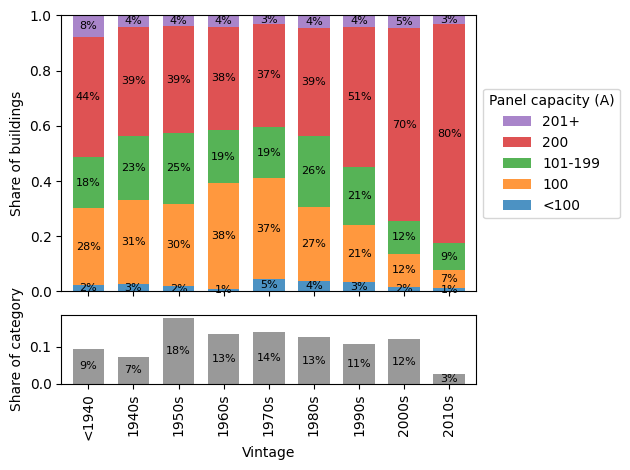

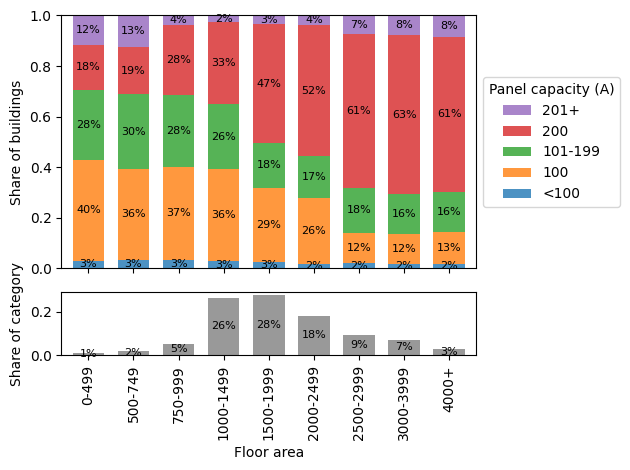

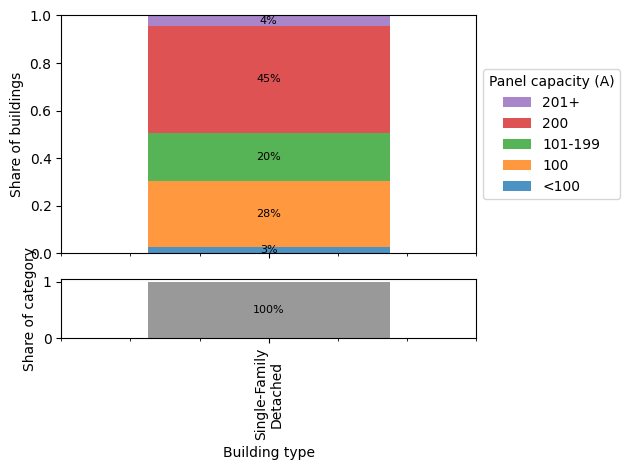

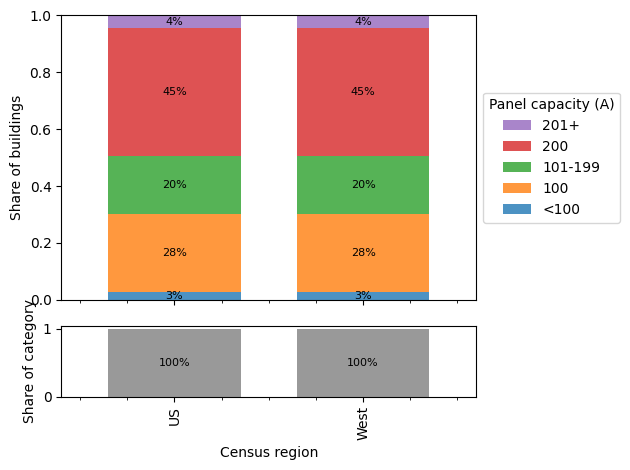

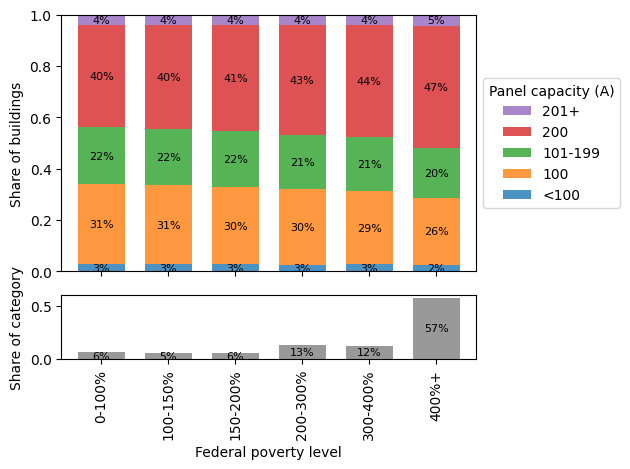

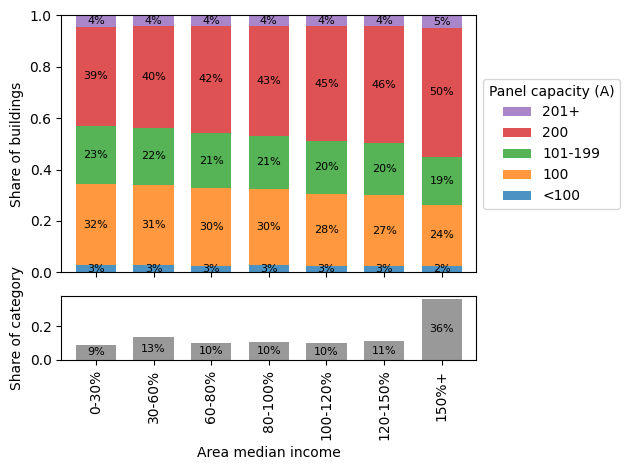

In [27]:
groupby_cols = [
    "build_existing_model.state",
    "build_existing_model.vintage",
    "build_existing_model.geometry_floor_area",
    "build_existing_model.geometry_building_type_recs",
    "build_existing_model.census_region", 
    "build_existing_model.federal_poverty_level",
    "build_existing_model.area_median_income",
]
x_labels = [
    "State",
    "Vintage",
    "Floor area",
    "Building type",
    "Census region", # include additional col for US
    "Federal poverty level",
    "Area median income",
]

for gbc, xlab in zip(groupby_cols, x_labels):
    metric_cols = ["<100", "100", "101-199", "200", "201+"]
    dfi = dfm.groupby(gbc)[metric_cols].sum()
    dfc = dfm.groupby(gbc)["building_id"].count()
    
    dfi = dfi.divide(dfi.sum(axis=1), axis=0)
    dfi = sort_index(sort_index(dfi, axis=0), axis=1)
    dfc = sort_index(dfc.divide(dfc.sum()))
    
    if gbc == "build_existing_model.census_region":
        # add US total to data
        us = (dfm[metric_cols].sum() / dfm[metric_cols].sum().sum()).rename("US")
        dfi = pd.concat([us, dfi.T], axis=1).T
        dfi.index.name = gbc

        dfc = pd.concat([pd.Series(1, index=["US"]), dfc], axis=0)
        dfc.index.name = gbc

    if gbc == "build_existing_model.state":
        print(f"no plot for {gbc}...")
        pass
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
        dfi.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax1)
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True, title="Panel capacity (A)")
        ax1.set_ylim(0,1)
        ax1.set_ylabel(f"Share of buildings")
    
        for i, row in dfi.reset_index(drop=True).iterrows():
            for j in range(len(row)):
                ax1.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
        dfc.plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
        ax2.set_xticks(ticks = range(len(dfc)), labels = format_labels(dfc.index))
        ax2.set_xlabel(xlab)
        ax2.set_ylabel("Share of category")
    
        for j in range(len(dfc)):
            ax2.text(j, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
        plt.tight_layout()
        
        metric = f"label_proba_by_{xlab}"
        fig.savefig(output_dir / f"stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")
        dfi.to_csv(output_dir / f"data__stacked_bar__{metric}.csv", index=True)

### [1.1] plot probability of labels by one variable - CA only

In [28]:
if not has_filter:
    state = "CA" # <---
    cond = dfm["build_existing_model.state"]==state

    #########################################
    groupby_cols = [
        "build_existing_model.vintage",
        "build_existing_model.geometry_floor_area",
        "build_existing_model.geometry_building_type_recs",
        "build_existing_model.census_region", 
        "build_existing_model.federal_poverty_level",
        "build_existing_model.area_median_income",
    ]
    x_labels = [
        "Vintage",
        "Floor area",
        "Building type",
        "Census region",
        "Federal poverty level",
        "Area median income",
    ]

    for gbc, xlab in zip(groupby_cols, x_labels):
        metric_cols = ["<100", "100", "101-199", "200", "201+"]
        dfi = dfm.loc[cond].groupby(gbc)[metric_cols].sum()
        dfc = dfm.loc[cond].groupby(gbc)["building_id"].count()
        
        dfi = dfi.divide(dfi.sum(axis=1), axis=0)
        dfi = sort_index(sort_index(dfi, axis=0), axis=1)
        dfc = sort_index(dfc.divide(dfc.sum()))
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
        dfi.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax1)
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True, title="Panel capacity (A)")
        ax1.set_ylim(0,1)
        ax1.set_ylabel(f"Share of buildings")

        for i, row in dfi.reset_index(drop=True).iterrows():
            for j in range(len(row)):
                ax1.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

        dfc.plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
        ax2.set_xticks(ticks = range(len(dfc)), labels = format_labels(dfc.index))
        ax2.set_xlabel(xlab)
        ax2.set_ylabel("Share of category")

        for j in range(len(dfc)):
            ax2.text(j, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

        fig.suptitle(f"{state} only")
        plt.tight_layout()
        
        metric = f"label_proba_by_{xlab}"
        fig.savefig(output_dir / f"CA_only__stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")
        dfi.to_csv(output_dir / f"CA_only__data__stacked_bar__{metric}.csv", index=True)

### [2] plot probability of labels by two variables

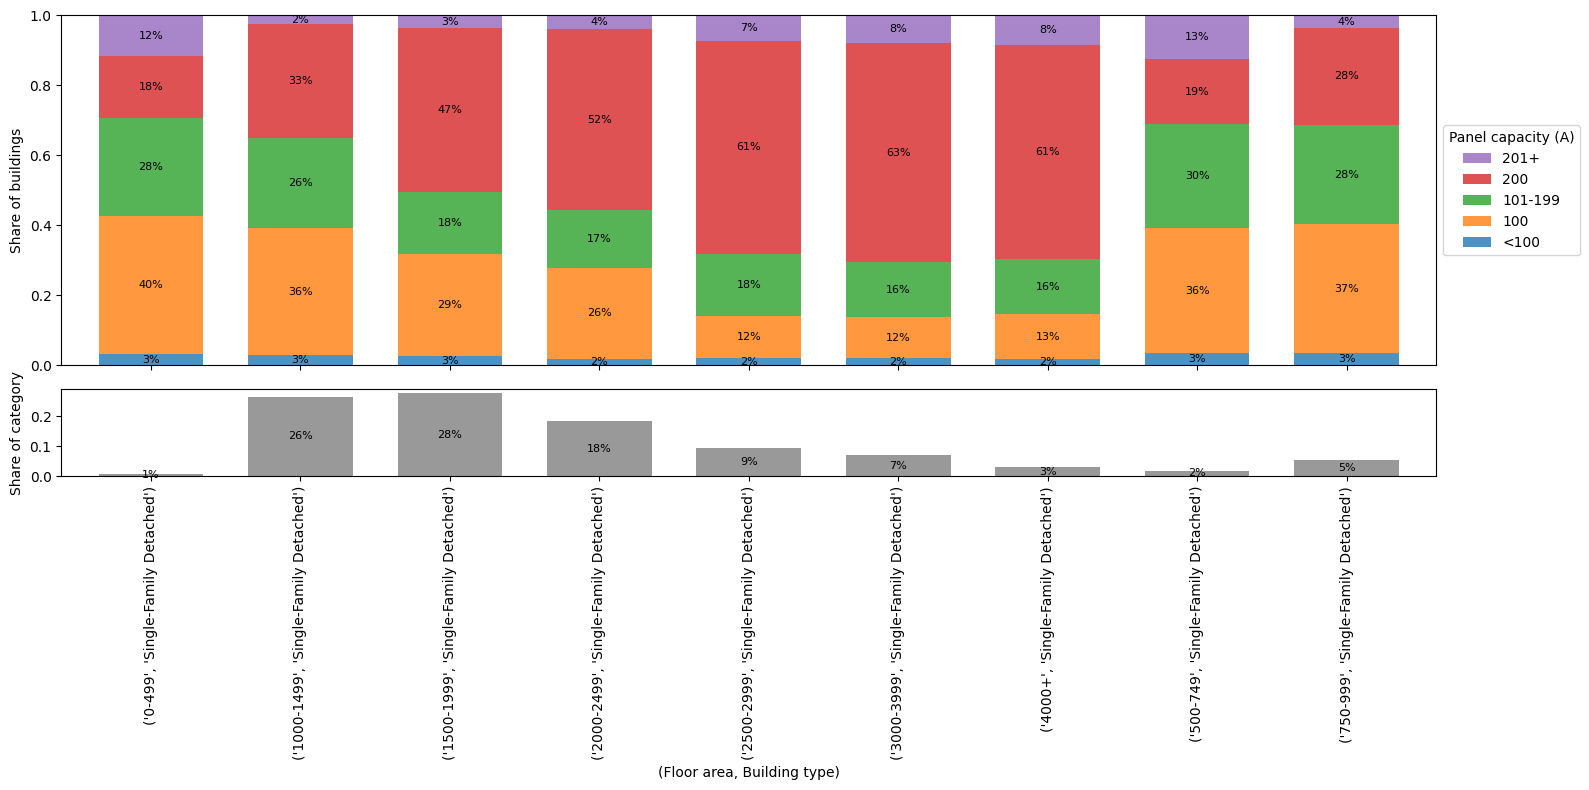

In [29]:
### alternative

gbc = ["build_existing_model.geometry_floor_area", "build_existing_model.geometry_building_type_recs"]
xlab = "(Floor area, Building type)"

metric_cols = ["<100", "100", "101-199", "200", "201+"]
dfi = dfm.groupby(gbc)[metric_cols].sum()
dfc = dfm.groupby(gbc)["building_id"].count()

dfi = dfi.divide(dfi.sum(axis=1), axis=0)
dfc = sort_index(dfc.divide(dfc.sum()))
dfi = sort_index(sort_index(dfi, axis=0), axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]}, figsize=(16,8))
dfi.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax1)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True, title="Panel capacity (A)")
ax1.set_ylim(0,1)
ax1.set_ylabel(f"Share of buildings")

for i, row in dfi.reset_index(drop=True).iterrows():
    for j in range(len(row)):
        ax1.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

dfc.plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
ax2.set_xticks(ticks = range(len(dfc)), labels = format_labels(dfc.index))
ax2.set_xlabel(xlab)
ax2.set_ylabel("Share of category")

for j in range(len(dfc)):
    ax2.text(j, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

plt.tight_layout()

metric = f"label_proba_by_{xlab}"
fig.savefig(output_dir / f"3stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")


### [2.1] plot probability of labels by one variable, subplot by Census Region

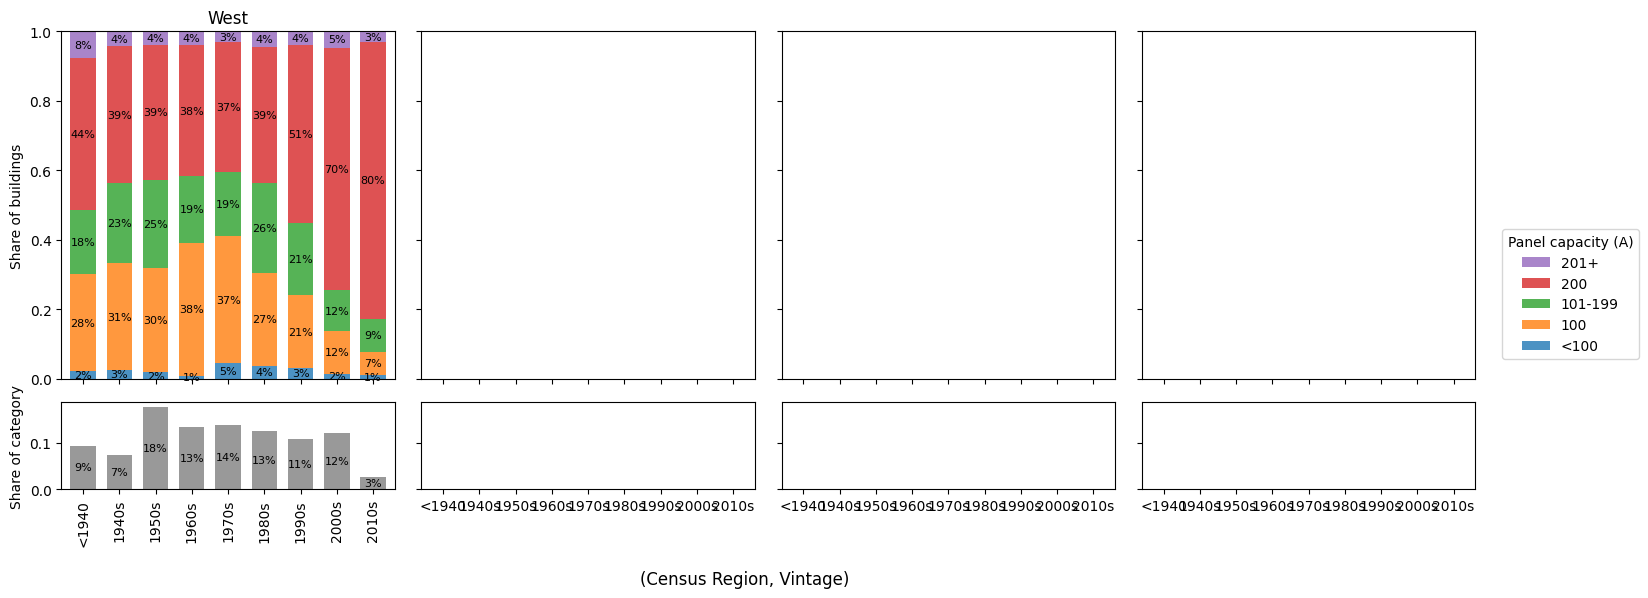

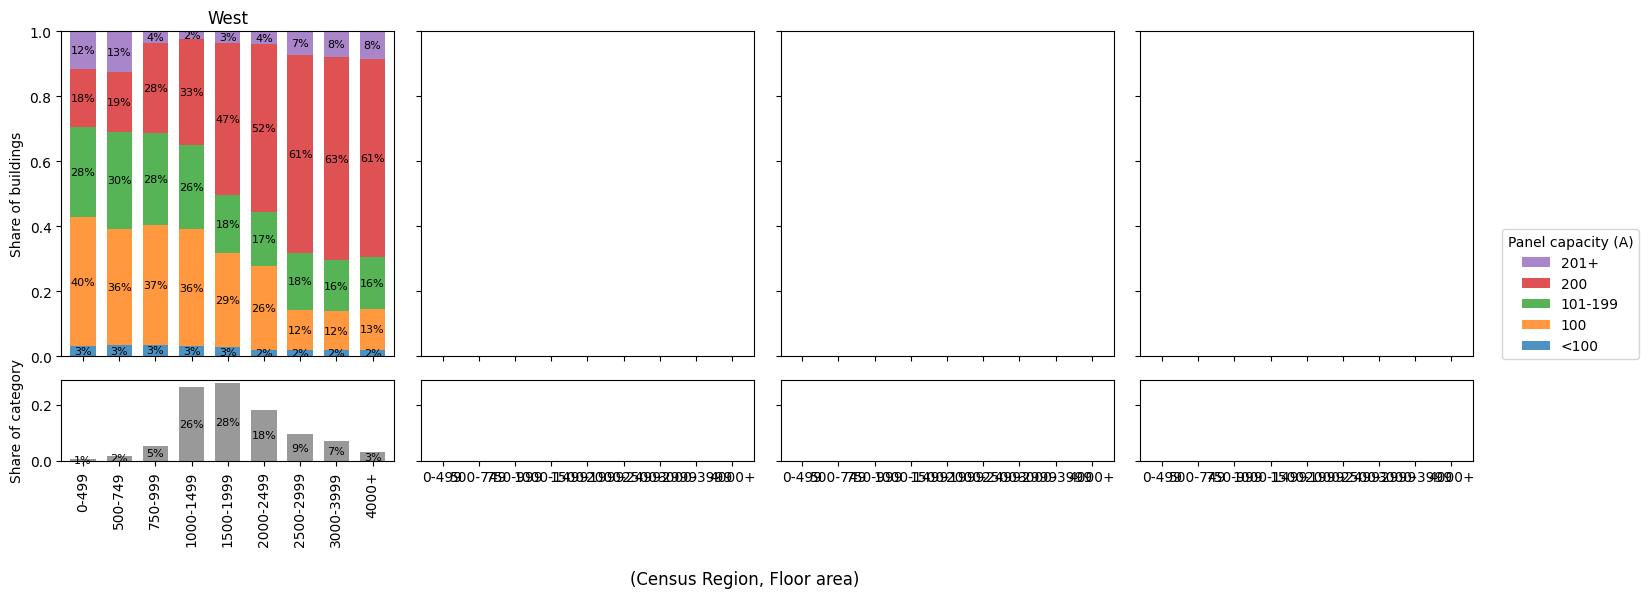

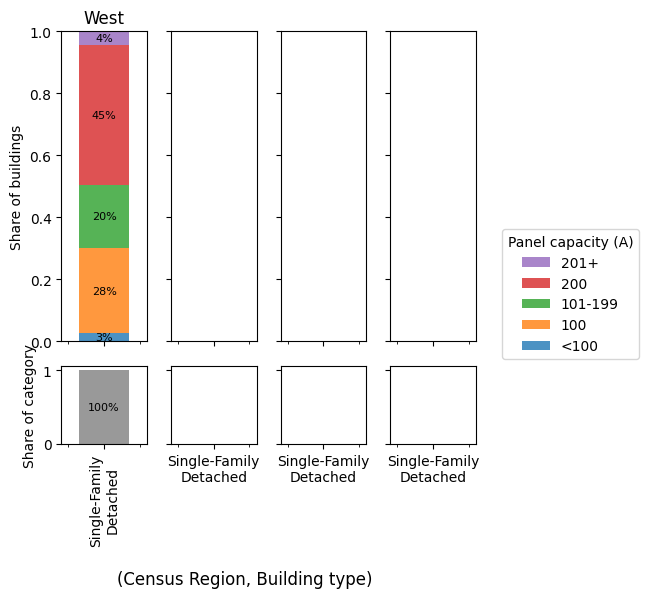

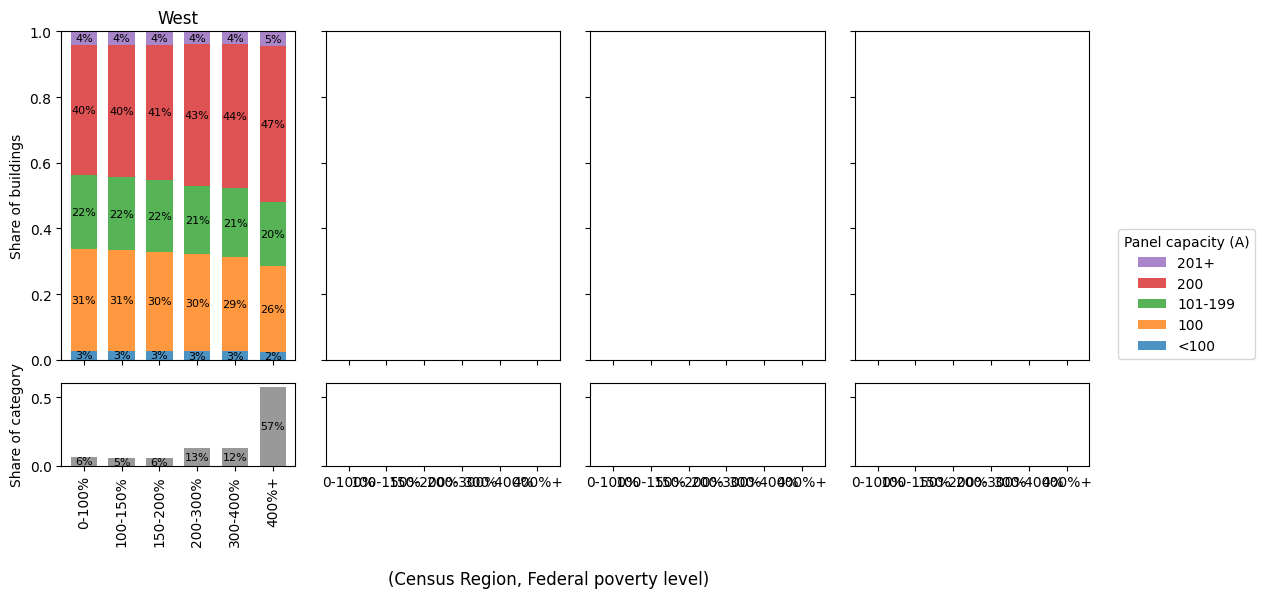

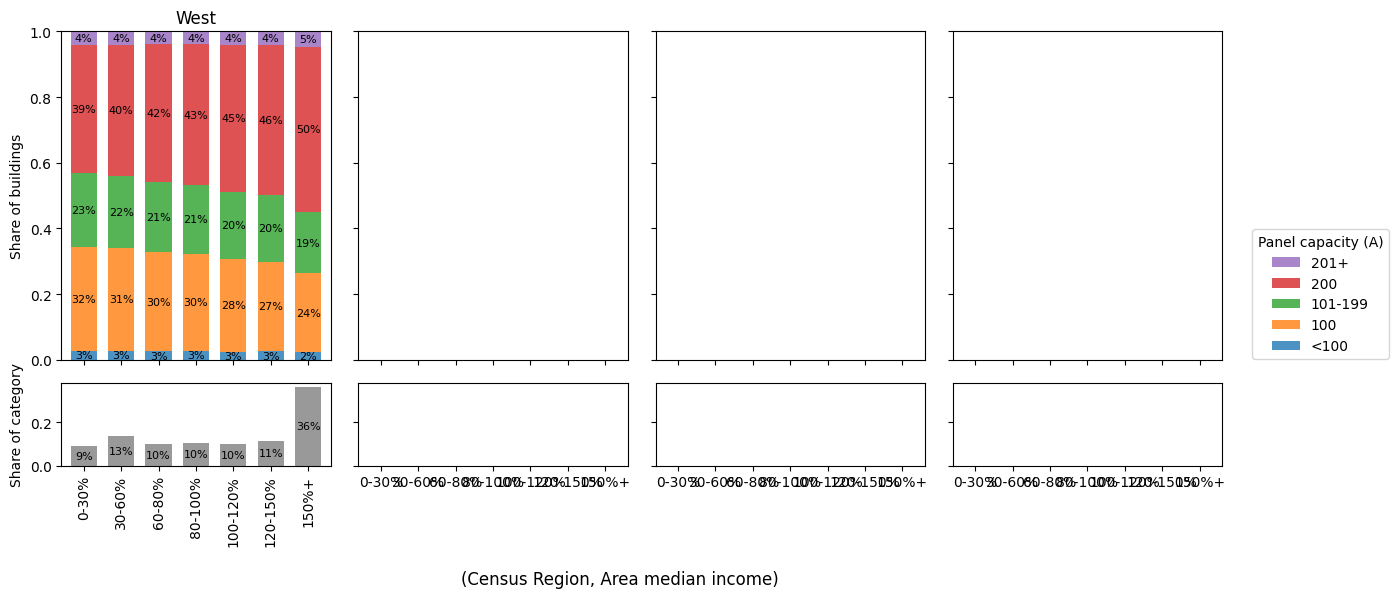

In [30]:
group_bys = [
    "build_existing_model.vintage",
    "build_existing_model.geometry_floor_area",
    "build_existing_model.geometry_building_type_recs",
    "build_existing_model.federal_poverty_level",
    "build_existing_model.area_median_income",
]
labels = [
    "Vintage",
    "Floor area",
    "Building type",
    "Federal poverty level",
    "Area median income",
]

for gbc, xlab in zip(group_bys, labels):
    xlab = f"(Census Region, {xlab})"
    
    metric_cols = ["<100", "100", "101-199", "200", "201+"]
    dfi = dfm.groupby(["build_existing_model.census_region", gbc])[metric_cols].sum()
    dfc = dfm.groupby(["build_existing_model.census_region", gbc])["building_id"].count()
    
    dfi = dfi.divide(dfi.sum(axis=1), axis=0)
    dfc = sort_index(dfc.divide(dfc.sum()))
    dfi = sort_index(sort_index(dfi, axis=0), axis=1)
    
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey="row", gridspec_kw={'height_ratios': [4,1]}, 
                             figsize=(3.75+1.25*dfm[gbc].nunique(), 6))
    for k, reg in enumerate(sorted(dfi.index.get_level_values(level=0).unique())):
        ax1 = axes[0,k]
        dfii = sort_index(sort_index(dfi.loc[(reg)], axis=0), axis=1)
        dfii.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax1, legend=False)
        # ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True, title="Panel capacity (A)")
        ax1.set_ylim(0,1)
        ax1.set_ylabel(f"Share of buildings")
        ax1.set_title(reg)
        
        for i, row in dfii.reset_index(drop=True).iterrows():
            for j in range(len(row)):
                ax1.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
                
        ax2 = axes[1,k]
        dfcc = sort_index(dfc.loc[(reg)])
        dfcc.plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2, legend=False)
        ax2.set_xticks(ticks = range(len(dfcc)), labels = format_labels(dfcc.index))
        ax2.set_xlabel(None)
        ax2.set_ylabel("Share of category")
        
        for j in range(len(dfcc)):
            ax2.text(j, dfcc.iloc[j]/2, f"{dfcc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(reversed(handles), reversed(labels), title="Panel capacity (A)", loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig.supxlabel(xlab)
    plt.tight_layout()
    
    metric = f"label_proba_by_{xlab}"
    fig.savefig(output_dir / f"2stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")

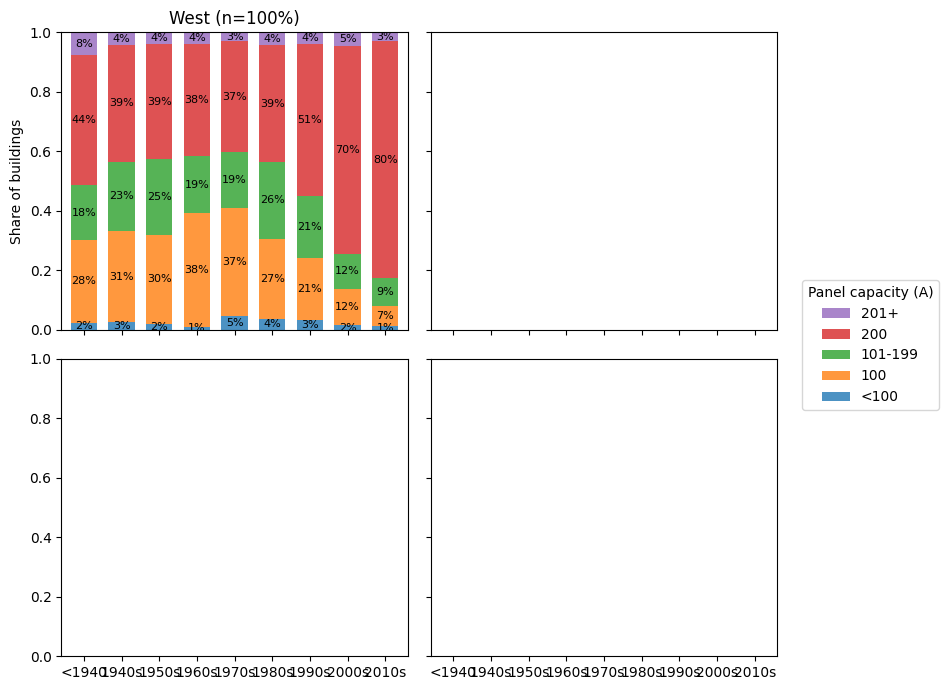

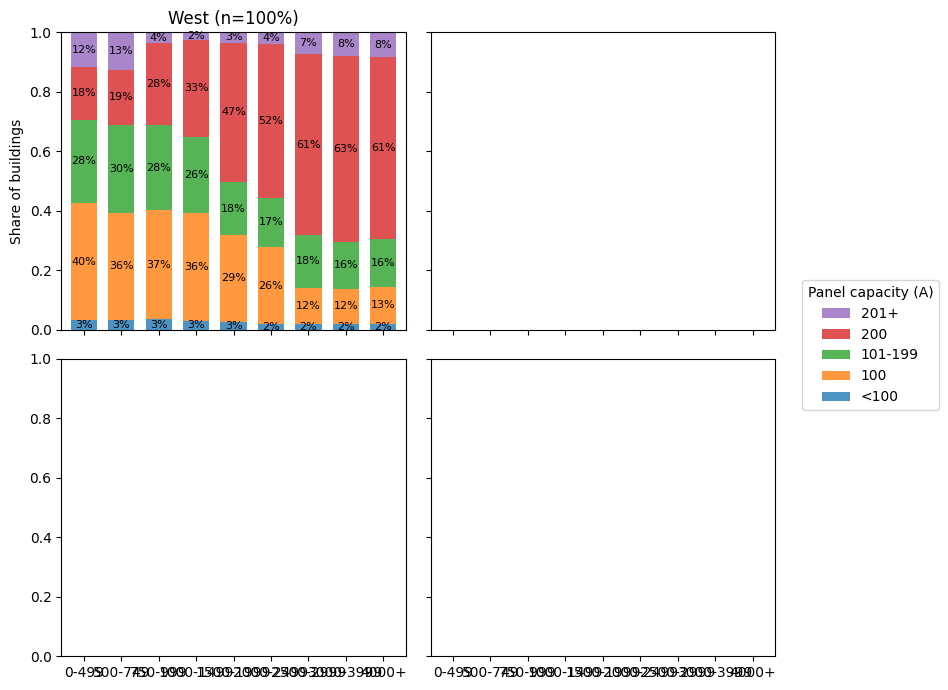

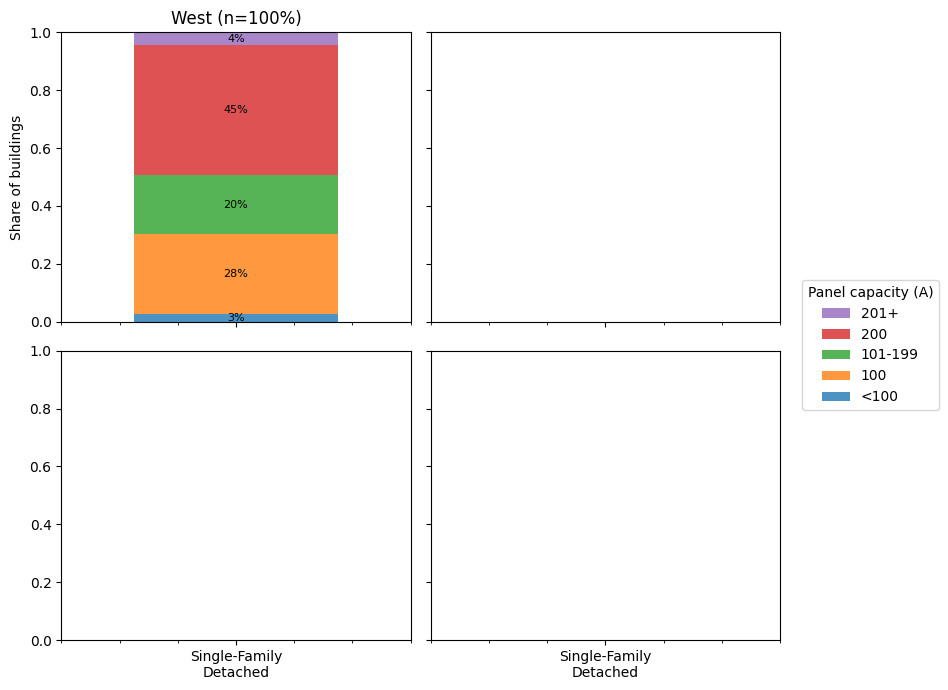

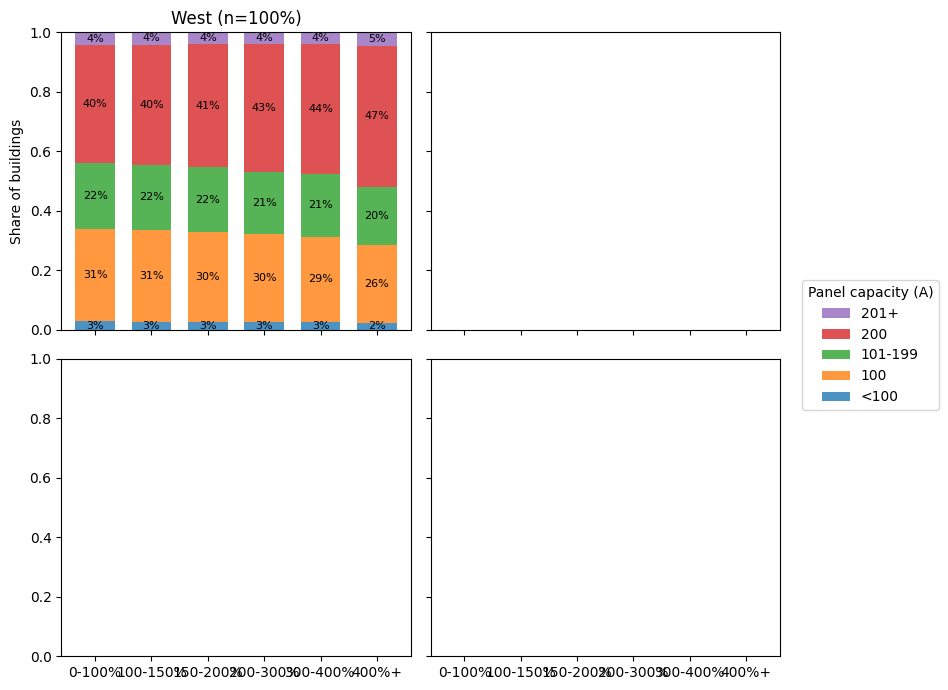

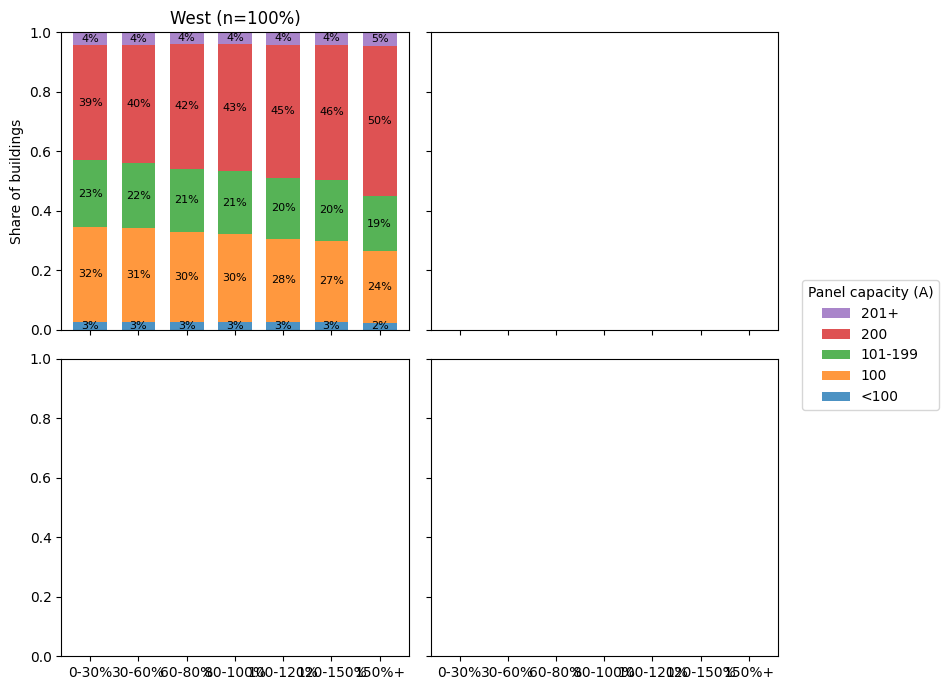

In [31]:
group_bys = [
    "build_existing_model.vintage",
    "build_existing_model.geometry_floor_area",
    "build_existing_model.geometry_building_type_recs",
    "build_existing_model.federal_poverty_level",
    "build_existing_model.area_median_income",
]
labels = [
    "Vintage",
    "Floor area",
    "Building type",
    "Federal poverty level",
    "Area median income",
]

for group_by, xlab in zip(group_bys, labels):
    subplot_by = "build_existing_model.census_region" # fixed - for # of axes and fig output name
    metric_cols = ["<100", "100", "101-199", "200", "201+"]
    dfi = dfm.groupby([subplot_by, group_by])[metric_cols].sum()
    
    dfi = dfi.divide(dfi.sum(axis=1), axis=0)
    dfi = sort_index(sort_index(dfi, axis=0), axis=1)
    dfi = dfi.unstack(level=0)
    dfi = dfi.swaplevel(i=-2, j=-1, axis=1).sort_index(axis=1)
    
    # get count of subplot_by
    dfc = dfm.groupby(subplot_by)["building_id"].count()
    dfc = dfc/dfc.sum()
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8,7))
    
    for k, reg in enumerate(dfi.columns.get_level_values(level=0).unique()):
        dfii = dfi.iloc[:, dfi.columns.get_level_values(level=0)==reg][reg]
        dfii = sort_index(sort_index(dfii, axis=0), axis=1)
    
        ax = axes[k //2,  k % 2]
        dfii.plot(kind="bar", stacked=True,  alpha=0.8, width=0.7, ax=ax, legend=False)
        ax.set_ylim(0,1)
        ax.set_ylabel(f"Share of buildings")
        ax.set_xlabel(xlab)
        ax.set_xticks(ticks = range(len(dfii)), labels = format_labels(dfii.index))
        ax.set_title(f"{reg} (n={dfc[reg]*100:.0f}%)")
        
        for i, row in dfii.reset_index(drop=True).iterrows():
            for j in range(len(row)):
                ax.text(i, row.iloc[0:j].sum()+row.iloc[j]/2, f"{row.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(reversed(handles), reversed(labels), title="Panel capacity (A)", loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

    metric = f"label_proba_by_{xlab}_subplot_by_census_region"
    fig.savefig(output_dir / f"1stacked_bar__{metric}.png", dpi=400, bbox_inches="tight")
    dfi.to_csv(output_dir / f"data__1stacked_bar__{metric}.csv", index=True)

### [3] plot rep value prediction vs. NEC

In [32]:
def bin_panel_cap_headroom(df_column):
    # 10A single heating element heater
    # 5kVA ~ 20A (dryer)
    # 7.2kVA ~ 30A (EVSE)
    # 12kVA ~ 50A (cooking)

    try:
        df_column = df_column.astype(float)
    except ValueError as e:
        df_column = df_column.replace('', np.nan).astype(float)

    df_out = pd.Series(np.nan, index=df_column.index)
    df_out.loc[df_column<=0] = "0A"
    df_out.loc[(df_column>0) & (df_column<10)] = "1-9A"
    df_out.loc[(df_column>=10) & (df_column<20)] = "10-19A"
    df_out.loc[(df_column>=20) & (df_column<30)] = "20-29A"
    df_out.loc[(df_column>=30) & (df_column<50)] = "30-49A"
    df_out.loc[(df_column>=50)] = "50+A"

    categories = ["0A", "1-9A", "10-19A", "20-29A", "30-49A", "50+A"]
    df_out = pd.Categorical(df_out, ordered=True, categories=categories)

    assert df_out.isna().sum() == 0, f"{df_out.isna().sum()} NA values after binning panel capacity headroom"

    return df_out

In [33]:
### combine prediction with NEC calc
print(f"Using {method} for representative value of panel amperage...")
df = dfn.join(
    dfm.set_index("building_id")[["predicted_panel_amp", "predicted_panel_amp_exact"]],
    on="building_id"
)
df["headroom_amp_220_83"] = df["predicted_panel_amp_exact"] - df["existing_amp_220_83"]
df["headroom_amp_220_87"] = df["predicted_panel_amp_exact"] - df["existing_amp_220_87"]
df["headroom_pct_220_83"] = (df["headroom_amp_220_83"] / df["predicted_panel_amp_exact"])*100
df["headroom_pct_220_87"] = (df["headroom_amp_220_87"] / df["predicted_panel_amp_exact"])*100

df["headroom_amp_bin_220_83"] = bin_panel_cap_headroom(df["headroom_amp_220_83"])
df["headroom_amp_bin_220_87"] = bin_panel_cap_headroom(df["headroom_amp_220_87"])
df

Using weighted for representative value of panel amperage...


,building_id,completed_status,build_existing_model.sample_weight,report_simulation_output.unmet_hours_cooling_hr,report_simulation_output.unmet_hours_heating_hr,build_existing_model.ahs_region,build_existing_model.ashrae_iecc_climate_zone_2004,build_existing_model.ashrae_iecc_climate_zone_2004_2_a_split,build_existing_model.bathroom_spot_vent_hour,build_existing_model.bedrooms,...,existing_amp_220_83,existing_amp_220_87,predicted_panel_amp,predicted_panel_amp_exact,headroom_amp_220_83,headroom_amp_220_87,headroom_pct_220_83,headroom_pct_220_87,headroom_amp_bin_220_83,headroom_amp_bin_220_87
0,16,Success,242.131013,1363.25,0.00,Non-CBSA Pacific,3C,3C,Hour6,3,...,76.537298,35.885417,200,200,123.462702,164.114583,61.731351,82.057292,50+A,50+A
1,17,Success,242.131013,0.00,0.00,Non-CBSA Pacific,4C,4C,Hour23,2,...,58.425285,19.375000,101-199,125,66.574715,105.625000,53.259772,84.500000,50+A,50+A
2,85,Success,242.131013,0.00,0.00,"CBSA San Francisco-Oakland-Hayward, CA",3C,3C,Hour6,3,...,53.153333,9.114583,200,200,146.846667,190.885417,73.423333,95.442708,50+A,50+A
3,106,Success,242.131013,0.00,0.00,Non-CBSA Pacific,3C,3C,Hour0,2,...,66.302667,19.739583,100,100,33.697333,80.260417,33.697333,80.260417,30-49A,50+A
4,111,Success,242.131013,9.50,0.00,"CBSA Riverside-San Bernardino-Ontario, CA",3B,3B,Hour7,4,...,82.343331,23.906250,100,100,17.656669,76.093750,17.656669,76.093750,10-19A,50+A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30668,549896,Success,242.131013,0.00,0.00,Non-CBSA Pacific,3B,3B,Hour4,4,...,86.520480,47.135417,200,200,113.479520,152.864583,56.739760,76.432292,50+A,50+A
30669,549948,Success,242.131013,0.00,25.25,Non-CBSA Pacific,3C,3C,Hour21,3,...,85.561667,41.718750,200,200,114.438333,158.281250,57.219167,79.140625,50+A,50+A
30670,549955,Success,242.131013,254.25,30.25,"CBSA Los Angeles-Long Beach-Anaheim, CA",3B,3B,Hour3,2,...,66.247564,23.385417,101-199,125,58.752436,101.614583,47.001949,81.291667,50+A,50+A
30671,549993,Success,242.131013,7.25,54.75,"CBSA San Francisco-Oakland-Hayward, CA",3C,3C,Hour3,5,...,71.476166,35.833333,101-199,125,53.523834,89.166667,42.819067,71.333333,50+A,50+A


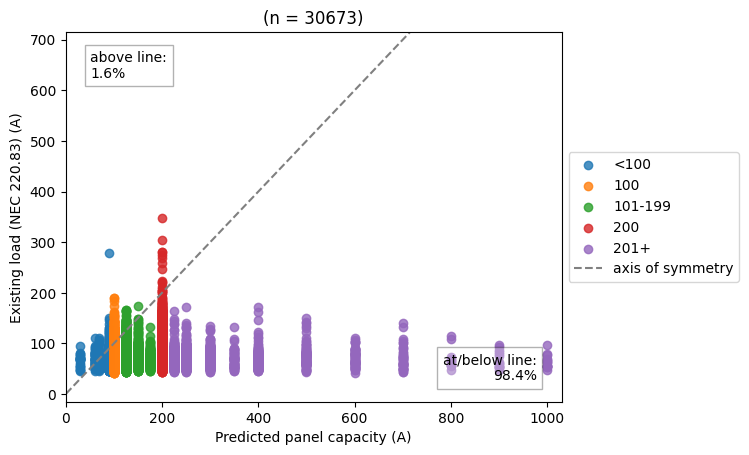

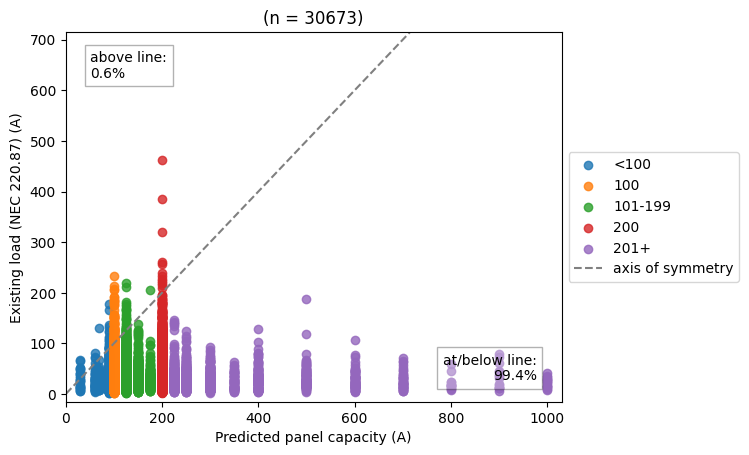

In [34]:
# scatter plots
y_metrics = [
    "existing_amp_220_83",
    "existing_amp_220_87",
]

y_labels = [
    "Existing load (NEC 220.83) (A)",
    "Existing load (NEC 220.87) (A)",
]

for y_metric, y_label in zip(y_metrics, y_labels):
    x_metric = "predicted_panel_amp_exact"
    x_label = "Predicted panel capacity (A)"
    
    title = None
    dfp = df[[x_metric, y_metric, "predicted_panel_amp"]].dropna(how="any")
    assert dfp[x_metric].dtype == int, f"{x_metric=} is of type {dfp[x_metric].dtype=}"
    assert dfp[y_metric].dtype == float, f"{y_metric=} is of type {dfp[y_metric].dtype=}"
    
    fig, ax = plt.subplots()
    for bin, color in zip(
        ["<100", "100", "101-199", "200", "201+"],
        ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'],
    ):
        x = dfp.loc[dfp["predicted_panel_amp"]==bin, x_metric]
        y = dfp.loc[dfp["predicted_panel_amp"]==bin, y_metric]
        ax.scatter(x, y, label=bin, c=color, alpha=0.8)
        
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(0, 1030)
    ax.set_ylim(-15, 715)
    ax.margins(x=0, y=0)
    
    lxy = np.array([
        min(ax.get_xlim()[0], ax.get_ylim()[0]), 
        max(ax.get_xlim()[1], ax.get_ylim()[1]), 
        ])
    ax.plot(lxy, lxy, label="axis of symmetry", ls="--", c="gray")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # calculate % above and at or below x=y
    frac = dfp[y_metric]/dfp[x_metric]
    frac_above = len(frac[frac>1]) / len(frac)
    frac_at_below = 1-frac_above
    ax.text(0.05, 0.95, f"above line:\n{frac_above*100:.1f}%", ha="left", va="top", transform=ax.transAxes, 
            bbox=dict(facecolor='w', alpha=0.3))
    ax.text(0.95, 0.05, f"at/below line:\n{frac_at_below*100:.1f}%", ha="right", va="bottom", transform=ax.transAxes, 
            bbox=dict(facecolor='w', alpha=0.3))
    
    title_ext = f"(n = {len(dfp)})"
    if title is not None:
        title += f" {title_ext}"
    else:
        title = title_ext
    ax.set_title(title)
    if output_dir is not None:
        fig.savefig(output_dir / f"scatter__{y_metric}_by_{x_metric}_{method}.png", dpi=400, bbox_inches="tight")

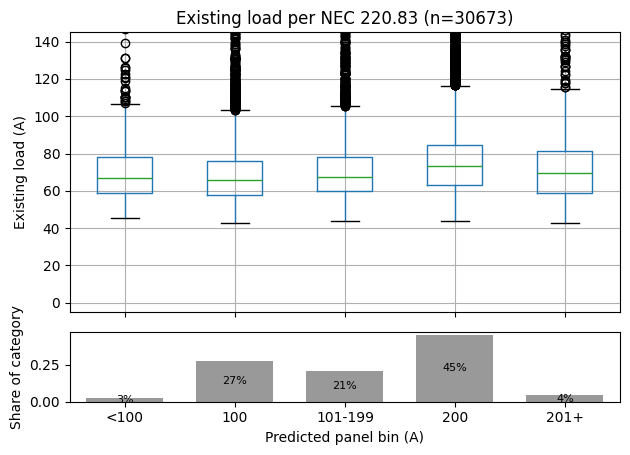

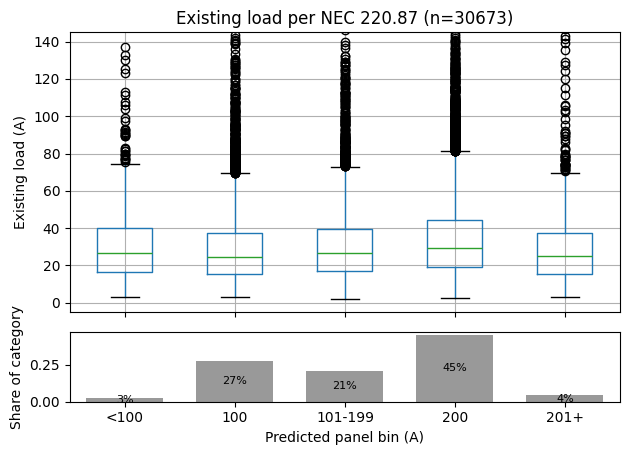

In [35]:
# box plots -- existing load
for panel_metric in [
    "existing_amp_220_83", 
    "existing_amp_220_87"
]:
    
    by_var = "predicted_panel_amp"
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
    df[[by_var, panel_metric]].boxplot(by=by_var, ax=ax1, showfliers=True)
    ax1.set_ylabel("Existing load (A)")
    ax1.set_ylim(-5,145) # adjust ylim by looking at natural ylim with showfliers=False in .boxplot()
    if "83" in panel_metric:
        ax1.set_title(f"Existing load per NEC 220.83 (n={len(df)})")
    else:
        ax1.set_title(f"Existing load per NEC 220.87 (n={len(df)})")
    
    dfc = sort_index(df[by_var].value_counts()) / len(df)
    pd.concat([
        pd.Series(0, index=[""]),
        dfc], axis=0).plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
    ax2.set_xlim(0.5,len(dfc)+0.5)
    ax2.set_xticks(ticks = range(1, len(dfc)+1), labels = format_labels(dfc.index), rotation=0)
    
    ax2.set_xlabel("Predicted panel bin (A)")
    ax2.set_ylabel("Share of category")
    
    for j in range(len(dfc)):
        ax2.text(j+1, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
    fig_file = f"box__{panel_metric}_by_{by_var}.png"
    if output_dir is not None:
        fig_file = output_dir / fig_file
    
    plt.suptitle(None)
    plt.tight_layout()
    fig.savefig(fig_file, dpi=400, bbox_inches="tight")

In [36]:
panel_labels = ["<100", "100", "101-199", "200", "201+"]
existing_load_methods = ["existing_amp_220_83", "existing_amp_220_87"]

for mtd in existing_load_methods:
    print(f"\nUsing {mtd} to calculate existing load:")
    
    for label in panel_labels:        
        cond = df["predicted_panel_amp"].isin([label]) 
        
        loads = df.loc[cond, mtd]
        upper = np.percentile(loads, 75) + 1.5*(np.percentile(loads, 75) - np.percentile(loads, 25))
        lower = np.percentile(loads, 25) - 1.5*(np.percentile(loads, 75) - np.percentile(loads, 25))
        cond_outliers = cond & ((df[mtd]<lower) | (df[mtd]>upper))
        n_outliers = len(df.loc[cond_outliers])
        pct_outliers = n_outliers / len(loads) * 100
        
        print(f"For label: {label}...")
        print(f" - outliers: {n_outliers} ( {pct_outliers:.02f} % ) ")
        
        cond_err = cond & (df["predicted_panel_amp_exact"]<=df[mtd])
        n_err = len(df.loc[cond_err])
        pct_err = n_err / len(loads) * 100
        print(f" - homes where existing load >= panel amp: {n_err} ( {pct_err:.02f} % ) ")
        print(f" - homes where existing load < panel amp (with headroom): {len(loads) - n_err} ( {(100-pct_err):.02f} % ) ")


Using existing_amp_220_83 to calculate existing load:
For label: <100...
 - outliers: 25 ( 3.06 % ) 
 - homes where existing load >= panel amp: 139 ( 17.01 % ) 
 - homes where existing load < panel amp (with headroom): 678 ( 82.99 % ) 
For label: 100...
 - outliers: 227 ( 2.70 % ) 
 - homes where existing load >= panel amp: 284 ( 3.38 % ) 
 - homes where existing load < panel amp (with headroom): 8115 ( 96.62 % ) 
For label: 101-199...
 - outliers: 185 ( 2.90 % ) 
 - homes where existing load >= panel amp: 57 ( 0.89 % ) 
 - homes where existing load < panel amp (with headroom): 6319 ( 99.11 % ) 
For label: 200...
 - outliers: 491 ( 3.56 % ) 
 - homes where existing load >= panel amp: 16 ( 0.12 % ) 
 - homes where existing load < panel amp (with headroom): 13762 ( 99.88 % ) 
For label: 201+...
 - outliers: 37 ( 2.84 % ) 
 - homes where existing load >= panel amp: 0 ( 0.00 % ) 
 - homes where existing load < panel amp (with headroom): 1303 ( 100.00 % ) 

Using existing_amp_220_87 to cal

In [37]:
# How much is existing load by NEC 220.87 lower than 220.83:
((df["existing_amp_220_87"]-df["existing_amp_220_83"])/df["existing_amp_220_83"]).describe()

count    30673.000000
mean        -0.576223
std          0.234214
min         -0.959765
25%         -0.727218
50%         -0.625029
75%         -0.482591
max          2.761848
dtype: float64

In [38]:
# How much is more headroom is calculated by NEC 220.87 than 220.83:
(df["headroom_amp_220_87"]-df["headroom_amp_220_83"]).describe()

count    30673.000000
mean        40.266822
std         16.924444
min       -180.853875
25%         35.018356
50%         42.442917
75%         48.537150
max        213.266413
dtype: float64

In [39]:
# error:= "predicted_panel_amp" > "existing_amp_220_87"
cond = df["predicted_panel_amp_exact"]<df["existing_amp_220_87"]
df_error = df.loc[cond]

print(len(df_error))
len(df_error) / len(df)

176


0.005737945424314544

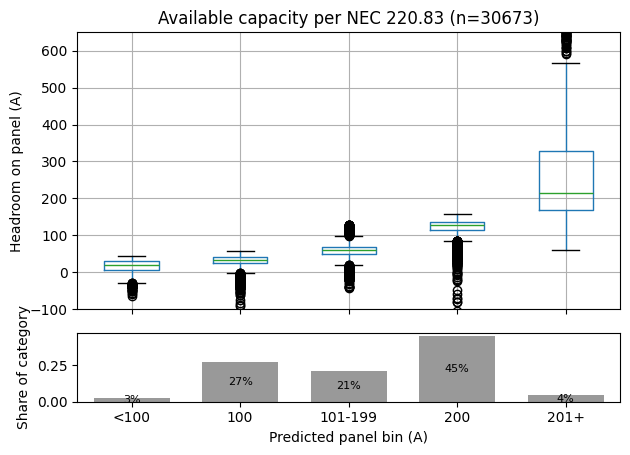

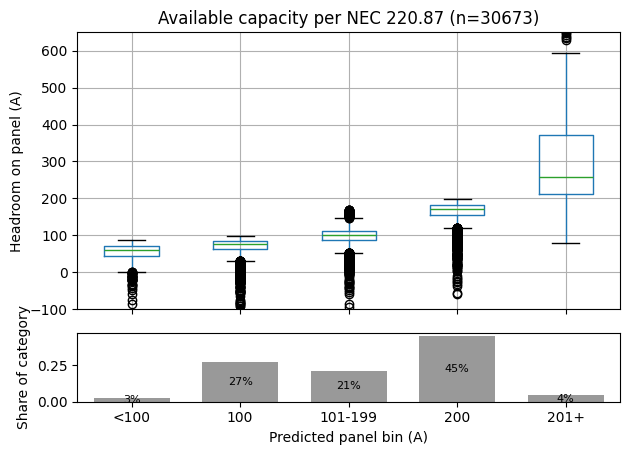

In [40]:
# box plots -- Head room abs
for panel_metric in [
    "headroom_amp_220_83", 
    "headroom_amp_220_87"
]:
    
    by_var = "predicted_panel_amp"
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
    df[[by_var, panel_metric]].boxplot(by=by_var, ax=ax1, showfliers=True)
    ax1.set_ylabel("Headroom on panel (A)")
    ax1.set_ylim(-100, 650) # adjust ylim by looking at natural ylim with showfliers=False in .boxplot()
    if "83" in panel_metric:
        ax1.set_title(f"Available capacity per NEC 220.83 (n={len(df)})")
    else:
        ax1.set_title(f"Available capacity per NEC 220.87 (n={len(df)})")
    
    dfc = sort_index(df[by_var].value_counts()) / len(df)
    pd.concat([
        pd.Series(0, index=[""]),
        dfc], axis=0).plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
    ax2.set_xlim(0.5,len(dfc)+0.5)
    ax2.set_xticks(ticks = range(1, len(dfc)+1), labels = format_labels(dfc.index), rotation=0)
    
    ax2.set_xlabel("Predicted panel bin (A)")
    ax2.set_ylabel("Share of category")
    
    for j in range(len(dfc)):
        ax2.text(j+1, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
    fig_file = f"box__{panel_metric}_by_{by_var}.png"
    if output_dir is not None:
        fig_file = output_dir / fig_file
    
    plt.suptitle(None)
    plt.tight_layout()
    fig.savefig(fig_file, dpi=400, bbox_inches="tight")

In [41]:
# tabulate fractions of homes by binned cap headroom
existing_load_methods = ["headroom_amp_bin_220_83", "headroom_amp_bin_220_87"]
for mtd in existing_load_methods:
    groupby_cols = ["predicted_panel_amp", mtd]
    dfi = df.groupby(groupby_cols)["building_id"].count().unstack().div(df.groupby(["predicted_panel_amp"])["building_id"].count(), axis=0)
    display(dfi)
    dfi.to_csv(output_dir / f"data__fraction_homes__{mtd}.csv", index=True)

headroom_amp_bin_220_83,0A,1-9A,10-19A,20-29A,30-49A,50+A
predicted_panel_amp,,,,,,
<100,0.170135,0.140759,0.195838,0.250918,0.242350,0.000000
100,0.033814,0.040243,0.102393,0.212644,0.538755,0.072151
101-199,0.008940,0.006274,0.011920,0.025094,0.218632,0.729141
200,0.001161,0.000290,0.000435,0.000944,0.004645,0.992524
201+,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


headroom_amp_bin_220_87,0A,1-9A,10-19A,20-29A,30-49A,50+A
predicted_panel_amp,,,,,,
<100,0.042840,0.017136,0.037944,0.045288,0.201958,0.654835
100,0.012025,0.005834,0.009763,0.015835,0.078224,0.878319
101-199,0.004391,0.001882,0.003607,0.004078,0.017880,0.968162
200,0.000871,0.000218,0.000581,0.000363,0.001887,0.996081
201+,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [42]:
panel_labels = ["<100", "100", "101-199", "200", "201+"]
existing_load_methods = ["headroom_amp_220_83", "headroom_amp_220_87"]

for mtd in existing_load_methods:
    print(f"\nUsing {mtd} to calculate existing load:")

    table = []
    for label in panel_labels:        
        cond = df["predicted_panel_amp"].isin([label]) 
        
        loads = df.loc[cond, mtd]
        upper = np.percentile(loads, 75) + 1.5*(np.percentile(loads, 75) - np.percentile(loads, 25))
        lower = np.percentile(loads, 25) - 1.5*(np.percentile(loads, 75) - np.percentile(loads, 25))
        cond_outliers = cond & ((df[mtd]<lower) | (df[mtd]>upper))
        n_outliers = len(df.loc[cond_outliers])
        pct_outliers = n_outliers / len(loads) * 100
        
        print(f"For label: {label}...")
        print(f" - outliers: {n_outliers} ( {pct_outliers:.02f} % ) ")
    


Using headroom_amp_220_83 to calculate existing load:
For label: <100...
 - outliers: 39 ( 4.77 % ) 
For label: 100...
 - outliers: 227 ( 2.70 % ) 
For label: 101-199...
 - outliers: 311 ( 4.88 % ) 
For label: 200...
 - outliers: 491 ( 3.56 % ) 
For label: 201+...
 - outliers: 83 ( 6.37 % ) 

Using headroom_amp_220_87 to calculate existing load:
For label: <100...
 - outliers: 35 ( 4.28 % ) 
For label: 100...
 - outliers: 372 ( 4.43 % ) 
For label: 101-199...
 - outliers: 321 ( 5.03 % ) 
For label: 200...
 - outliers: 552 ( 4.01 % ) 
For label: 201+...
 - outliers: 85 ( 6.52 % ) 


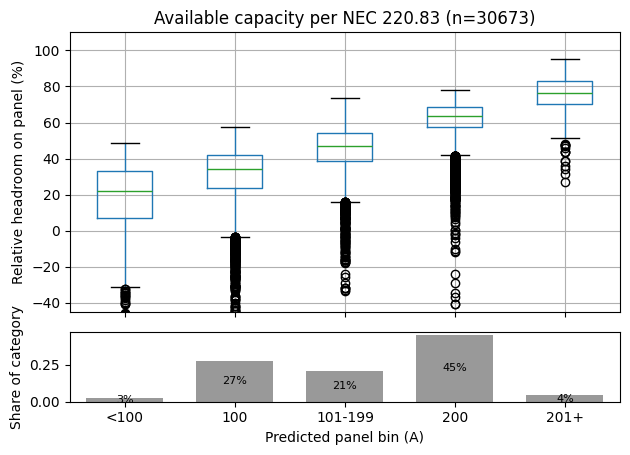

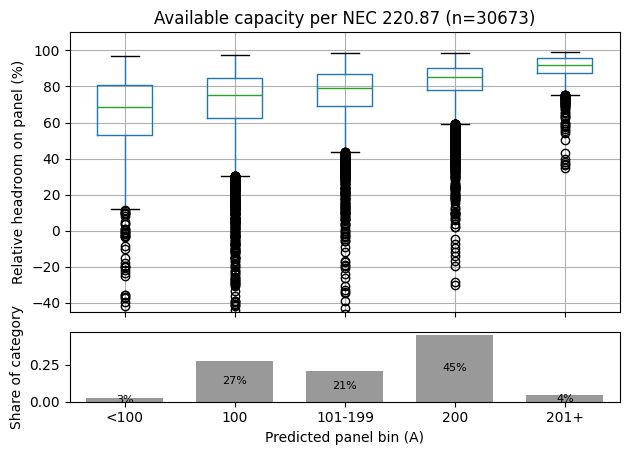

In [43]:
# box plots -- Head room %
for panel_metric in [
    "headroom_pct_220_83", 
    "headroom_pct_220_87"
]:
    
    by_var = "predicted_panel_amp"
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [4,1]})
    df[[by_var, panel_metric]].boxplot(by=by_var, ax=ax1, showfliers=True)
    ax1.set_ylabel("Relative headroom on panel (%)")
    ax1.set_ylim(-45, 110) # adjust ylim by looking at natural ylim with showfliers=False in .boxplot()
    if "83" in panel_metric:
        ax1.set_title(f"Available capacity per NEC 220.83 (n={len(df)})")
    else:
        ax1.set_title(f"Available capacity per NEC 220.87 (n={len(df)})")
    
    dfc = sort_index(df[by_var].value_counts()) / len(df)
    pd.concat([
        pd.Series(0, index=[""]),
        dfc], axis=0).plot(kind="bar", stacked=False, color="gray", alpha=0.8, width=0.7, ax=ax2)
    ax2.set_xlim(0.5,len(dfc)+0.5)
    ax2.set_xticks(ticks = range(1, len(dfc)+1), labels = format_labels(dfc.index), rotation=0)
    
    ax2.set_xlabel("Predicted panel bin (A)")
    ax2.set_ylabel("Share of category")
    
    for j in range(len(dfc)):
        ax2.text(j+1, dfc.iloc[j]/2, f"{dfc.iloc[j]*100:.0f}%", ha="center", va="center", fontsize=8)
    
    fig_file = f"box__{panel_metric}_by_{by_var}.png"
    if output_dir is not None:
        fig_file = output_dir / fig_file
    
    plt.suptitle(None)
    plt.tight_layout()
    fig.savefig(fig_file, dpi=400, bbox_inches="tight")

### [4.1] State maps

In [82]:
panel_label1 = "% dwelling units"
title = "Electrical panels 100 Amp or less"
dfcond = df.loc[df["predicted_panel_amp"].isin(["<100", "100"])]
data1 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label1)
data1.index.name = "State"
data1 = data1.reset_index()

# plot
fig = px.choropleth(data1, locations='State', color=panel_label1, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data1['State'], text=data1[panel_label1].round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )
fig.show()
fig_file = f"map__{panel_label1}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=1000, height=500)

In [45]:
panel_label2 = "% dwelling units"
title = "Electrical panels 200 Amp or more"
dfcond = df.loc[df["predicted_panel_amp"].isin(["200", "201+"])]
data2 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "State"
data2 = data2.reset_index()

# plot
fig = px.choropleth(data2, locations='State', color=panel_label2, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data2['State'], text=data2[panel_label2].round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )

fig.show()
fig_file = f"map__{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=800, height=500)

In [85]:
panel_label1 = "% dwelling units"
title = "30 Amp or more available capacity (NEC 220.83)"
dfcond = df.loc[df["headroom_amp_bin_220_83"].isin(["30-49A", "50+A"])]
data1 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label1)
data1.index.name = "State"
data1 = data1.reset_index()

# plot
fig = px.choropleth(data1, locations='State', color=panel_label1, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data1['State'], text=data1[panel_label1].round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )

fig.show()
fig_file = f"map__{panel_label1}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=800, height=500)

In [47]:
panel_label2 = "% dwelling units"
title = "30 Amp or more available capacity (NEC 220.87)"
dfcond = df.loc[df["headroom_amp_bin_220_87"].isin(["30-49A", "50+A"])]
data2 = (dfcond.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["build_existing_model.state"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "State"
data2 = data2.reset_index()

# plot
fig = px.choropleth(data2, locations='State', color=panel_label2, title=title,
                    locationmode="USA-states", color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa")
fig.add_scattergeo(locations=data2['State'], text=data2[panel_label2].round(0), 
                   locationmode="USA-states", mode='markers+text', opacity=1,
                   textfont=dict(color="black", size=10),
                   marker=dict(color="white", size=15, opacity=0.6),
                  )

fig.show()
fig_file = f"map__{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file
pio.write_image(fig, fig_file, scale=6, width=800, height=500)

### [4.2] County maps

In [49]:
# create county fips for plotting
df["county_fips"] = df["build_existing_model.county_and_puma"].apply(lambda x: x.split(",")[0])
df["county_fips"] = df["county_fips"].apply(lambda x: x[1:3]+x[4:7])


In [87]:
# county level plot
panel_label1 = "% dwelling units"
title = "Electrical panels 100 Amp or less"
dfcond = df.loc[df["predicted_panel_amp"].isin(["<100", "100"])]
data1 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label1)
data1.index.name = "County"
data1 = data1.reset_index()

fig = px.choropleth(data1, geojson=counties, locations='County', color=panel_label1, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()
fig_file = f"map__county_{panel_label1}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

In [81]:
panel_label2 = "% dwelling units"
title = "Electrical panels 200 Amp or more"
dfcond = df.loc[df["predicted_panel_amp"].isin(["200", "201+"])]
data2 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "County"
data2 = data2.reset_index()

fig = px.choropleth(data2, geojson=counties, locations='County', color=panel_label2, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"t":0, "l":0,"b":0}, height=500, width=800)
fig.show()
fig_file = f"map__county_{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

In [86]:
panel_label1 = "% dwelling units"
title = "30 Amp or more available capacity (NEC 220.83)"
dfcond = df.loc[df["headroom_amp_bin_220_83"].isin(["30-49A", "50+A"])]
data1 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label1)
data1.index.name = "County"
data1 = data1.reset_index()

fig = px.choropleth(data1, geojson=counties, locations='County', color=panel_label1, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()
fig_file = f"map__county_{panel_label1}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

In [84]:
panel_label2 = "% dwelling units"
title = "30 Amp or more available capacity (NEC 220.87)"
dfcond = df.loc[df["headroom_amp_bin_220_87"].isin(["30-49A", "50+A"])]
data2 = (dfcond.groupby(["county_fips"])["build_existing_model.sample_weight"].sum() / \
        df.groupby(["county_fips"])["build_existing_model.sample_weight"].sum()*100).rename(panel_label2)
data2.index.name = "County"
data2 = data2.reset_index()

fig = px.choropleth(data2, geojson=counties, locations='County', color=panel_label2, title=title,
                           color_continuous_scale=px.colors.sequential.RdBu_r, scope="usa",)

fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin={"r":0,"t":0, "l":0,"b":0}, height=500, width=800)
fig.show()
fig_file = f"map__county_{panel_label2}_{title}.png"
if output_dir is not None:
    fig_file = output_dir / fig_file

pio.write_image(fig, fig_file, scale=6, width=800, height=500)

### Miscellaneous Script

In [ ]:
### investigate outliers in full survey dataset
data = pd.read_excel("/Uses/lliu2/Documents/GitHub/resstock2/Electrical_Panels_EUSS/model_20240122/outlier_summary.xlsx", 
                   sheet_name="floor area", header=1)
data

In [ ]:
fab = data["geometry_floor_area_bin"].unique()

res = []
for bin in fab:
    dat = data.loc[data["geometry_floor_area_bin"]==bin,["panel_amp_pre", "total count"]]
    panel_list = np.repeat(dat["panel_amp_pre"], dat["total count"]).values
    
    # calculate IQR
    P75, P25 = np.percentile(panel_list, 75), np.percentile(panel_list, 25)
    LB = P25 - 1.5*(P75-P25)
    UB = P75 + 1.5*(P75-P25)
    LB_outliers = panel_list[panel_list<LB]
    UB_outliers = panel_list[panel_list>UB]

    res.append(
        pd.Series([bin, len(panel_list), LB, UB, len(LB_outliers), len(UB_outliers), LB_outliers, UB_outliers],
                  index = ["floor_area", "n_samples", "lower_bound", "upper_bound", "n_lb_outliers", "n_ub_outliers", "lb_outliers", "ub_outliers"]
                  )
    )
res = pd.concat(res, axis=1).transpose()

res